In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts, LoraSynchronizer

# LoRa Synchronization

### Fase 1: Búsqueda de Upchirps

1. **Segmentación del Buffer de Recepción:**
   - El buffer de recepción (`rx_signal`) se segmenta en segmentos de tamaño `SPC * 2^SF` muestras, donde `SPC` es `samples_per_chip` y `SF` es `spreading_factor`. Este tamaño se denomina `SPS` (Samples Per Symbol).

2. **Iteración con Desplazamientos de una Muestra:**
   - Se itera sobre el buffer de recepción con desplazamientos de una muestra a la vez. En cada iteración, se extrae un segmento del tamaño `SPS` para analizar.

3. **Detección de Upchirps:**
   - Por cada segmento, se intenta detectar un `upchirp` utilizando el método `detect_chirp`. Si no se detecta un `upchirp`, se continúa iterando.

4. **Inicio de la Fase 2:**
   - Al detectar un `upchirp`, se utiliza ese índice como el punto de partida para la Fase 2.


### Fase 2: Verificación del Preambulo

1. **Verificación de la Secuencia de Preambulo:**
   - A partir del índice donde se detectó el `upchirp`, se verifica si los siguientes segmentos también contienen `upchirps` y `downchirps` en la secuencia esperada para un preámbulo.

2. **Reconstrucción del Preambulo:**
   - Se reconstruye el preámbulo detectando `upchirps` y `downchirps` consecutivos. Si se detecta un `downchirp` seguido de otro `downchirp`, se asume que se ha encontrado el final del preámbulo.

3. **Cálculo del Índice de Inicio del Payload:**
   - Si se encuentra el preámbulo, se calcula el índice de inicio del payload (`payload_index`) y se pasa a la Fase 3 si `samples_per_chip` es mayor que 1.


### Fase 3: Refinamiento de la Sincronización



1. **Evaluación de Desplazamientos:**
   - Si `samples_per_chip` es mayor que 1, se realiza un refinamiento de la sincronización evaluando diferentes desplazamientos (`offsets`) para encontrar el que proporcione la mejor calidad de sincronización.

2. **Cálculo de la Calidad de Sincronización:**
   - Se evalúa la calidad de sincronización para cada desplazamiento calculando la magnitud media de los símbolos demodulados.

3. **Selección del Mejor Desplazamiento:**
   - Se selecciona el desplazamiento que asegura la mayor calidad de sincronización y se ajusta el índice de inicio del payload (`payload_index`) en consecuencia.

### Fase 4: Detección del fin del paquete

Una vez se tiene el índice exacto donde está el payload, se tiene en cuenta de que el paquete que se envió tiene un pequeño header implícito: Siempre el primer símbolo de la carga útil contiene la cantidad de símbolos que le siguen y que conforman a la totalidad del paquete.

De esta forma, si yo demodulo este símbolo obtengo la cantidad de símbolos que faltan, y por lo tanto, al tenes la cantidad de muestras por símbolo, cuantas muestras quedan.


### Código

In [2]:
class LoraSync():
    def validate_parameters(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        if spreading_factor not in range(7, 13) or not isinstance(spreading_factor, int):
            raise ValueError('The spreading factor must be an integer between 7 and 12.')
        if samples_per_chip < 1 or not isinstance(preamble_number, int):
            raise ValueError('Samples per chip must be a positive integer')
        if not isinstance(demodulator, LoraDemodulator):
            raise ValueError('Demodulator must be an instance of LoraDemodulator')
        if preamble_number < 1 or not isinstance(preamble_number, int):
            raise ValueError('Preamble number must be a positive integer')
        
    def __init__(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        self.validate_parameters(spreading_factor, samples_per_chip, demodulator, preamble_number)
        self._spreading_factor = spreading_factor
        self._samples_per_chip = samples_per_chip
        self._demodulator = demodulator 
        self._preamble_number = preamble_number

    def _detect_chirp(self, signal_segment, chirp_type):
        """Helper function to detect specific chirp types in a given signal segment."""
        chirp_type = 'upchirp' if chirp_type == 'downchirp' else 'downchirp'
        return self._demodulator.demodulate_symbol(signal_segment, chirp_type) == 0

    def _get_samples_per_symbol(self):
        return self._samples_per_chip * 2 ** self._spreading_factor

    def synchronize_rx_buffer(self, rx_signal):
        """Synchronizes the received signal by detecting the LoRa preamble."""
        sps = self._get_samples_per_symbol()
        preamble_found, payload_index, package_length = self._phase1sync(rx_signal)
        #Ignoring of the payload length symbol
        payload_index += sps

        if preamble_found:
            message_samples = (package_length) * sps 
            payload_start = payload_index
            payload_end = payload_index + message_samples
            rx_payload_segment = rx_signal[payload_start: payload_end]
            return rx_payload_segment
        else:
            print('Synchronization failed!')
            return None
    
    def _phase1sync(self, rx_signal):
        """Searches for the preamble in the signal, by first searching for upchirps."""
        sps = self._get_samples_per_symbol()
        print('Synchronization started...')
        print("Phase 1: Searching for upchirps...")
        for i in range(len(rx_signal)):
            # Extract the iterative segment to analyze
            segment = rx_signal[i:i + sps]
            if len(segment) < sps:
                break
            # Check if the segment is an upchirp
            if self._detect_chirp(segment, 'upchirp'):
                print('Upchirp found at index: ', i)
                # Check if the next symbols are members of the preamble (phase 2)
                preamble_found, payload_index, reconstructed_preamble = self._phase2sync(rx_signal, i)
                
                if preamble_found:
                    
                    offset = 0
                    if self._samples_per_chip > 1:
                        
                        payload_index, offset = self._phase3sync(rx_signal, i, payload_index, reconstructed_preamble)

                    # This would be phase 4
                    package_length = self._demodulator.demodulate_symbol(rx_signal[payload_index:payload_index + sps], 'downchirp')
                    
                    print('Synchronization successful!\n-----------------------------------------------------------')
                    
                    print('Preamble found at index: ', i + offset)
                    if self._samples_per_chip > 1:
                        print('Refined by an offset of: ', offset)
                    print('Package length: ', package_length)
                    print('Payload starts at index: ', payload_index)
                    upchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_UPCHIRP)
                    downchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    print(f'Reconstructed preamble: [{upchirps + 1} upchirps, {downchirps} downchirps]')

                    return True, payload_index, package_length
        return False, -1, -1
    
    def _phase2sync(self, rx_signal, candidate_index):
        """Searches for the preamble in the vicinity of a candidate upchirp."""
        sps = self._get_samples_per_symbol()
        
        current_index = candidate_index + sps
        
        reconstructed_preamble = []
        while True:
            segment = rx_signal[current_index:current_index + sps]
            if len(segment) < sps:
                break
            if self._detect_chirp(segment, 'upchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_UPCHIRP)
                current_index += sps
                continue
            elif self._detect_chirp(segment, 'downchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                current_index += sps
                alleged_second_downchip = rx_signal[current_index:current_index + sps]
                if self._detect_chirp(alleged_second_downchip, 'downchirp'):
                    reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    payload_index = int(current_index + sps * 1.25)
                    print("Phase 2: Ensuring that the candidate upchirp is a preamble member...")
                    print("Preamble allegedly found at index: ", candidate_index)
                    return True, payload_index, reconstructed_preamble
                else:
                    break
            else:
                break
        return False, -1, -1
    
    def _evaluate_offset(self, rx_signal, candidate_index, offset, upchirps, downchirps):
        """Helper function to evaluate the quality of a given offset."""
        sps = self._get_samples_per_symbol()
        upchirps_index = candidate_index + sps + offset
        downchirps_index = upchirps_index + sps * upchirps
        upchirps_length = sps * upchirps
        downchirps_length = sps * downchirps
        demod = []
        upchirps_segment = rx_signal[upchirps_index:upchirps_index + upchirps_length]
        downchirps_segment = rx_signal[downchirps_index:downchirps_index + downchirps_length]
        upchirp_symbols, upchirp_magnitudes = self._demodulator.demodulate_symbols(upchirps_segment, 'downchirp', return_magnitude=True)
        downchirp_symbols, downchirp_magnitudes = self._demodulator.demodulate_symbols(downchirps_segment, 'upchirp', return_magnitude=True)
        magnitudes = np.concatenate((np.abs(upchirp_magnitudes), np.abs(downchirp_magnitudes)))
        mean_magnitude = np.mean(magnitudes)
        demod.extend(upchirp_symbols)
        demod.extend(downchirp_symbols)
        if demod.count(0) != len(demod):
            return 0
        return mean_magnitude

        

    def _phase3sync(self, rx_signal, candidate_index, payload_index, reconstructed_preamble):
        """Chooses the best offset to ensure a proper synchronization."""
        sps = self._get_samples_per_symbol()
        print("Phase 3: Refining synchronization index... (SPC > 1 requires it)")
        upchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_UPCHIRP)
        downchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
        offset = 0
        offset_magnitudes = []
        for offset in range(0, self._samples_per_chip):
            mean_magnitude = self._evaluate_offset(rx_signal, candidate_index, offset, upchirps, downchirps)
            offset_magnitudes.append(mean_magnitude)
        chosen_offset = np.argmax(offset_magnitudes)
        print("Offset quality measurements: ", offset_magnitudes)
        print("Offset that ensures Highest Quality Synchronization: ", chosen_offset)
        payload_index = chosen_offset + payload_index
        return payload_index, chosen_offset


Synchronization started...
Phase 1: Searching for upchirps...
Upchirp found at index:  278
Upchirp found at index:  279
Upchirp found at index:  280
Upchirp found at index:  281
Upchirp found at index:  282
Upchirp found at index:  298
Upchirp found at index:  299
Upchirp found at index:  300
Upchirp found at index:  301
Upchirp found at index:  302
Upchirp found at index:  318
Upchirp found at index:  319
Upchirp found at index:  320
Upchirp found at index:  337
Upchirp found at index:  338
Upchirp found at index:  339
Upchirp found at index:  357
Upchirp found at index:  467
Upchirp found at index:  584
Upchirp found at index:  599
Upchirp found at index:  600
Upchirp found at index:  783
Upchirp found at index:  826
Upchirp found at index:  1026
Upchirp found at index:  1027
Upchirp found at index:  1063
Upchirp found at index:  1184
Upchirp found at index:  1185
Upchirp found at index:  1264
Upchirp found at index:  1319
Upchirp found at index:  1341
Upchirp found at index:  1342
U

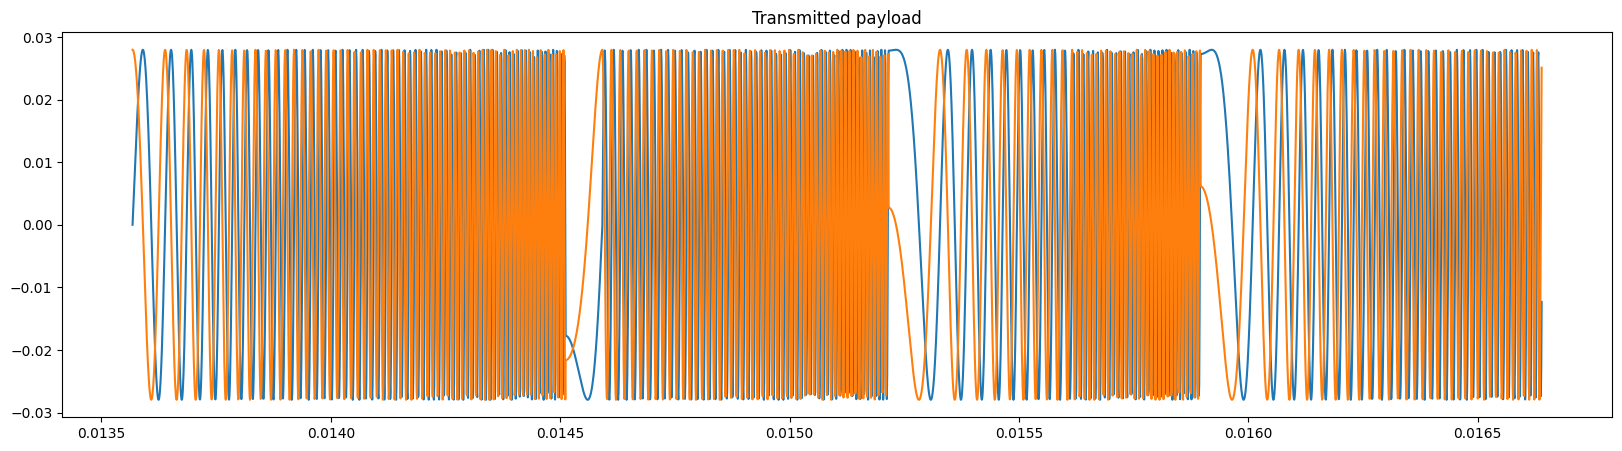

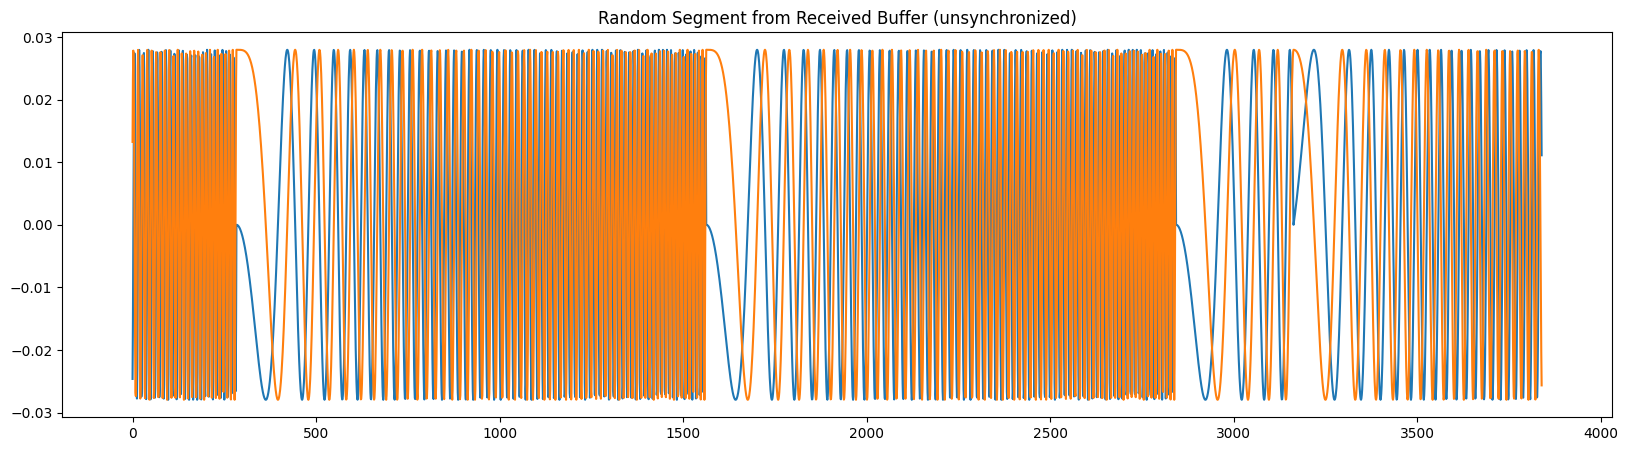

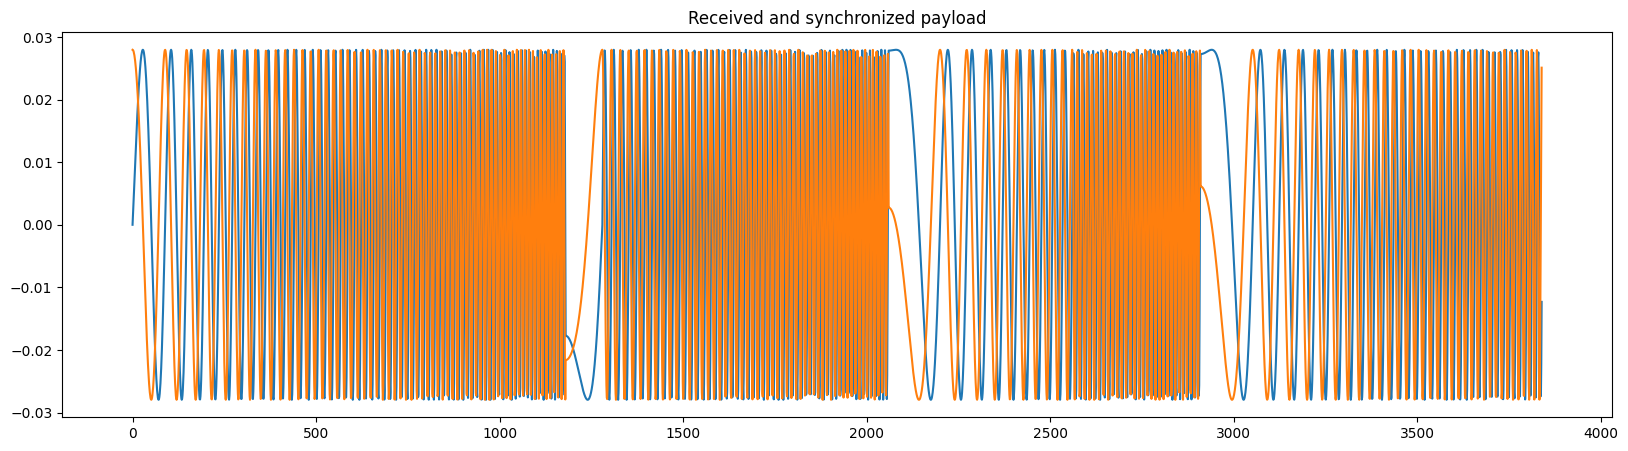

In [3]:
def ciclify(signal):
    """Shifts the signal in a cyclical nature to simulate a real-world scenario where the signal's first sample isn't alligned to the first received one."""
    rx_buffer = np.array([signal, signal, signal]).flatten()
    roll_factor = np.random.randint(0, len(rx_buffer)//2)
    rx_buffer = np.roll(rx_buffer, roll_factor)

    return rx_buffer


# ----- Playground -----
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 10
preamble_number = 8
payload = [10, 50, 93]

modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
synchronizer = LoraSynchronizer(spreading_factor, samples_per_chip, demodulator, preamble_number)

timeline, frequency, signal = modulator.modulate_implicit_package(preamble_number, payload)
plt.figure(figsize=(20, 5))
payload_start = int((preamble_number + 4.25 + 1)*(samples_per_chip * 2 ** spreading_factor))
plt.plot(timeline[payload_start:], np.imag(signal[payload_start:]))
plt.plot(timeline[payload_start:], np.real(signal[payload_start:]))
plt.title('Transmitted payload')

rx_buffer = ciclify(signal)
plt.figure(figsize=(20, 5))
plt.plot(np.imag(rx_buffer[:len(signal[payload_start:])]))
plt.plot(np.real(rx_buffer[:len(signal[payload_start:])]))
plt.title('Random Segment from Received Buffer (unsynchronized)')

sync_rx_payload = synchronizer.synchronize_rx_buffer(rx_buffer)
plt.figure(figsize=(20, 5))
plt.plot(np.imag(sync_rx_payload))
plt.plot(np.real(sync_rx_payload))
plt.title('Received and synchronized payload')
if sync_rx_payload is not None:
    received_symbols = demodulator.demodulate_symbols(sync_rx_payload)
    print('Received symbols: ', received_symbols)
